This section import two datasets and combine them into one dataset with more features for loan approval prediction.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 10)

pd.set_option('display.max_columns', 15)


read_loan_with_8C = pd.read_csv("Files/loan_approval_8_columns.csv")

read_approval_dataSet_extra = pd.read_csv("Files/loan_approval_dataset_extra.csv")

# print(read_approval_dataSet_extra.columns)

df_extra_selected = read_approval_dataSet_extra[[' no_of_dependents', ' education',
                                                 ' self_employed', ' income_annum', ' loan_amount', ' commercial_assets_value',
                                                 ' luxury_assets_value', ' bank_asset_value']]

# print(df_extra_selected)

combined_loan_dataset = pd.concat([read_loan_with_8C, df_extra_selected], axis=1)

print(combined_loan_dataset)

combined_loan_dataset.to_csv("Files/loan_approval_preprocessed.csv", index= False)


                 name              city    income  credit_score  loan_amount  \
0        Allison Hill         East Jill  113810.0         389.0      39698.0   
1        Brandon Hall     New Jamesside   44592.0         729.0      15446.0   
2        Rhonda Smith      Lake Roberto   33278.0         584.0      11189.0   
3     Gabrielle Davis  West Melanieview  127196.0         344.0      48823.0   
4        Valerie Gray         Mariastad   66048.0         496.0      47174.0   
...               ...               ...       ...           ...          ...   
4264              NaN               NaN       NaN           NaN          NaN   
4265              NaN               NaN       NaN           NaN          NaN   
4266              NaN               NaN       NaN           NaN          NaN   
4267              NaN               NaN       NaN           NaN          NaN   
4268              NaN               NaN       NaN           NaN          NaN   

      years_employed  points  ...      

This section perform imputation on missing values in the dataset.

In [30]:
from numpy import exceptions
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

# read from load data loan approval preprocessed

try:
  loan_approval_preprocessed = pd.read_csv("Files/loan_approval_preprocessed.csv")
  print(loan_approval_preprocessed.tail(10))

except Exception as ex:
  print(f"error: {ex}")


#imputation
# Calculate monthly income from 'income_annum' and assign it to the 'income' column.
# This is done using vectorized operations for efficiency.
if ' income_annum' in loan_approval_preprocessed.columns:
    loan_approval_preprocessed['income'] = (loan_approval_preprocessed[' income_annum'] / 12).round(2)

else:
    print("Warning: 'income_annum' column not found. Cannot calculate monthly income.")

# Define a robust imputation function that can handle both numerical/categorical and boolean columns
def sample_data_imputation(columns, is_boolean=False):
  missing_mask = loan_approval_preprocessed[columns].isna()
  n_missing = missing_mask.sum()

  if n_missing == 0:
    return # No missing values, nothing to do

  existing_values = loan_approval_preprocessed[columns].dropna()

  if is_boolean:
    # Check if existing_values are actually binary before calculating mean for binomial distribution
    if existing_values.isin([0, 1]).all():
      p_success = existing_values.mean()
      samples_for_imputation = np.random.binomial(n=1, p=p_success, size=n_missing)
    else:
      print(f"Warning: Column '{columns}' is marked as boolean but contains non-binary values. Falling back to random sampling.")
      new_existing= existing_values.replace({
        "TRUE": 1, "True": 1, True: 1,
        "FALSE": 0, "False": 0, False: 0})
      samples_for_imputation = np.random.choice(new_existing, size=n_missing, replace=True)
  else:
    samples_for_imputation = np.random.choice(existing_values, size=n_missing, replace=True)

  loan_approval_preprocessed.loc[missing_mask, columns] = samples_for_imputation


#filling in the credit score column
sample_data_imputation(columns='credit_score')

#filling in the loan amount column
sample_data_imputation(columns='loan_amount')

#filling in the years of employment column
sample_data_imputation(columns='years_employed')

#filling in the points column
sample_data_imputation(columns='points')

#filling in the loan_approved column (boolean)
sample_data_imputation(columns='loan_approved', is_boolean=True)

#filling in the name column
sample_data_imputation(columns='name')

#filling in the city column
sample_data_imputation(columns='city')


loan_approval_preprocessed.to_csv("Files/loan_approval_preprocessed.csv", index=False)

                       name               city     income  credit_score  \
4259         Courtney Smith     East Craigfurt  375000.00           785   
4260           Meagan Smith         Port Chloe  733333.33           744   
4261  Mr. William Davis DDS      Dennischester  250000.00           333   
4262             Chad Reyes      North Jonfurt  108333.33           717   
4263           Tonya Oliver     New Kelseyview  416666.67           325   
4264           Linda Miller         New Kristy   83333.33           464   
4265            Lori Brooks     Kristenchester  275000.00           645   
4266        Elizabeth Clark          Lake Ryan  541666.67           362   
4267      Victoria Williams  Port Kathyborough  341666.67           804   
4268         Christina Cobb        West Walter  766666.67           724   

      loan_amount  years_employed  points  ... self_employed  income_annum  \
4259         9183              33      35  ...           Yes       4500000   
4260        25361 

In [5]:
import pandas as pd

# 1. Load the loan_approval_preprocessed.csv file into a pandas DataFrame named loan_approval_preprocessed.
# Ensure the DataFrame is loaded if not already in the kernel state
if 'loan_approval_preprocessed' not in locals():
    loan_approval_preprocessed = pd.read_csv("loan_approval_preprocessed.csv")

# 2. Define appropriate bins for years_employed
# Example bins: 0-5 years (Entry-Level), 6-20 years (Mid-Career), 21-40 years (Experienced)
bins = [0, 5, 20, 40] # Adjusted upper bound to match max years_employed

# 3. Define corresponding labels for these bins
labels = ['Entry-Level', 'Mid-Career', 'Experienced']

# 4. Use pd.cut() to create a new column, employment_tenure_category
loan_approval_preprocessed['employment_tenure_category'] = pd.cut(
    loan_approval_preprocessed['years_employed'],
    bins=bins,
    labels=labels,
    right=True, # Intervals include the rightmost edge, e.g., (0, 5] means up to 5 years inclusive
    include_lowest=True # The first interval will include the lowest value
)

# 5. Display the value counts of the newly created employment_tenure_category column
print("\nDistribution of Employment Tenure Categories:")
print(loan_approval_preprocessed['employment_tenure_category'].value_counts())

# Display the first few rows with the new column
print("\nDataFrame head with new employment_tenure_category column:")
print(loan_approval_preprocessed[['years_employed', 'employment_tenure_category']].head())

# 6. Save the modified loan_approval_preprocessed DataFrame back to loan_approval_preprocessed.csv
loan_approval_preprocessed.to_csv("Files/loan_approval_preprocessed.csv", index=False)


Distribution of Employment Tenure Categories:
employment_tenure_category
Experienced    2177
Mid-Career     1538
Entry-Level     554
Name: count, dtype: int64

DataFrame head with new employment_tenure_category column:
   years_employed employment_tenure_category
0            27.0                Experienced
1            28.0                Experienced
2            13.0                 Mid-Career
3            29.0                Experienced
4             4.0                Entry-Level



Descriptive Statistics:
       bank_asset_value  income_annum  credit_score
count      4.269000e+03  4.269000e+03   4269.000000
mean       4.976692e+06  5.059124e+06    574.995081
std        3.250185e+06  2.806840e+06    160.362474
min        0.000000e+00  2.000000e+05    300.000000
25%        2.300000e+06  2.700000e+06    434.000000
50%        4.600000e+06  5.100000e+06    575.000000
75%        7.100000e+06  7.500000e+06    716.000000
max        1.470000e+07  9.900000e+06    850.000000


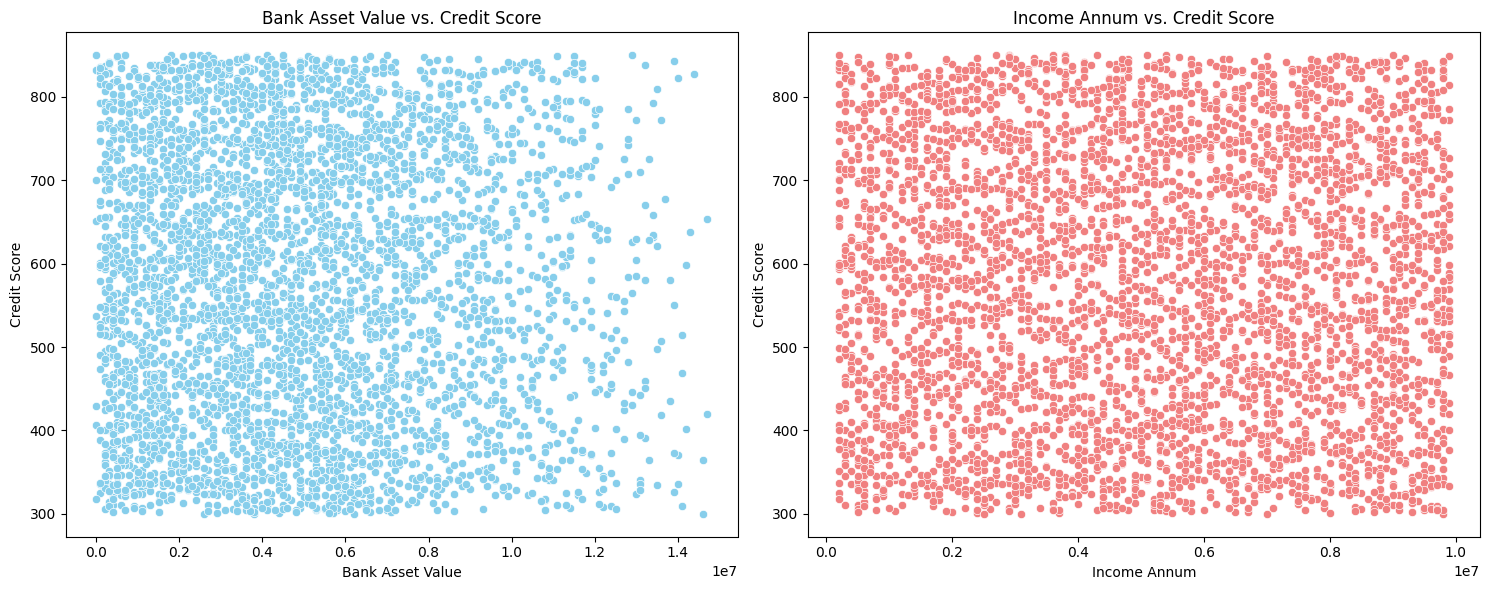


Pearson Correlation Coefficients:
Correlation between 'bank_asset_value' and 'credit_score': -0.0109
Correlation between 'income_annum' and 'credit_score': -0.0035


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load the loan_approval_preprocessed.csv file into a pandas DataFrame.
loan_approval_preprocessed = pd.read_csv("Files/loan_approval_preprocessed.csv")

# 2. Display descriptive statistics for the specified columns
print("\nDescriptive Statistics:")
print(loan_approval_preprocessed[['bank_asset_value', 'income_annum', 'credit_score']].describe())

# 3. Create scatter plots to visualize the relationships
plt.figure(figsize=(15, 6))

# Plot 1: 'bank_asset_value' vs. 'credit_score'
plt.subplot(1, 2, 1)
sns.scatterplot(x='bank_asset_value', y='credit_score', data=loan_approval_preprocessed, color='skyblue')
plt.title('Bank Asset Value vs. Credit Score')
plt.xlabel('Bank Asset Value')
plt.ylabel('Credit Score')

# Plot 2: 'income_annum' vs. 'credit_score'
plt.subplot(1, 2, 2)
sns.scatterplot(x='income_annum', y='credit_score', data=loan_approval_preprocessed, color='lightcoral')
plt.title('Income Annum vs. Credit Score')
plt.xlabel('Income Annum')
plt.ylabel('Credit Score')

plt.tight_layout()
plt.show()

# 4. Calculate and display the Pearson correlation coefficients
print("\nPearson Correlation Coefficients:")
correlation_bank_asset_credit_score = loan_approval_preprocessed['bank_asset_value'].corr(loan_approval_preprocessed['credit_score'])
correlation_income_annum_credit_score = loan_approval_preprocessed['income_annum'].corr(loan_approval_preprocessed['credit_score'])

print(f"Correlation between 'bank_asset_value' and 'credit_score': {correlation_bank_asset_credit_score:.4f}")
print(f"Correlation between 'income_annum' and 'credit_score': {correlation_income_annum_credit_score:.4f}")

This section identifies outliers in specified numerical columns using the IQR method and visualizes them with box plots.

Outlier Detection using IQR Method:
-----------------------------------
Column: 'credit_score'
  Q1: 434.00, Q3: 716.00, IQR: 282.00
  Lower Bound: 11.00, Upper Bound: 1139.00
  Number of outliers: 0 (0.00% of total records)


Column: 'bank_asset_value'
  Q1: 2300000.00, Q3: 7100000.00, IQR: 4800000.00
  Lower Bound: -4900000.00, Upper Bound: 14300000.00
  Number of outliers: 5 (0.12% of total records)


Column: 'income_annum'
  Q1: 2700000.00, Q3: 7500000.00, IQR: 4800000.00
  Lower Bound: -4500000.00, Upper Bound: 14700000.00
  Number of outliers: 0 (0.00% of total records)




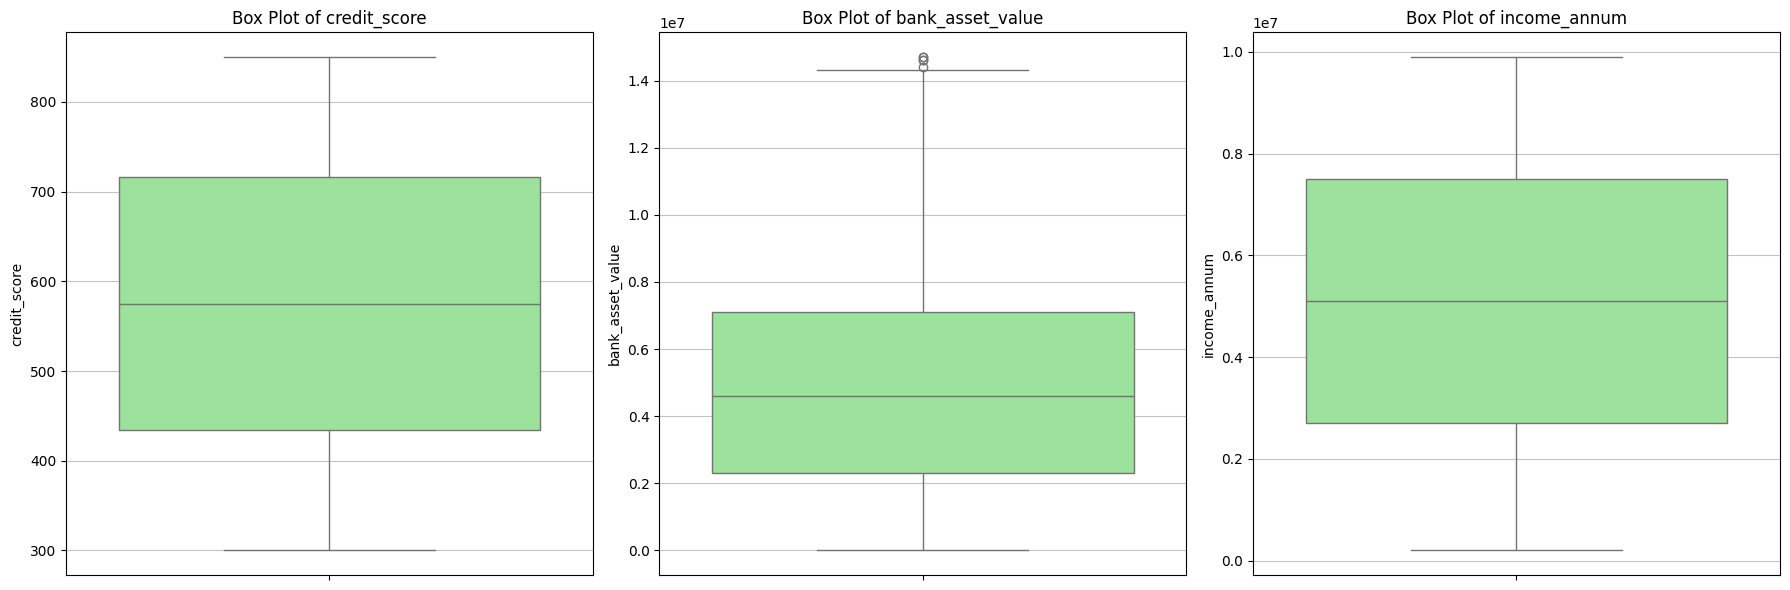

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the loan_approval_preprocessed.csv file into a pandas DataFrame named loan_approval_preprocessed.
# Ensure the DataFrame is loaded if not already in the kernel state
if 'loan_approval_preprocessed' not in locals():
    loan_approval_preprocessed = pd.read_csv("loan_approval_preprocessed.csv")

# 2. Define a list of columns for outlier detection
columns_for_outlier_detection = ['credit_score', 'bank_asset_value', 'income_annum']

print("Outlier Detection using IQR Method:")
print("-----------------------------------")

plt.figure(figsize=(18, 6))

# 3. For each column in the list:
for i, col in enumerate(columns_for_outlier_detection):
    # a. Calculate the first quartile (Q1) and third quartile (Q3).
    Q1 = loan_approval_preprocessed[col].quantile(0.25)
    Q3 = loan_approval_preprocessed[col].quantile(0.75)

    # b. Calculate the Interquartile Range (IQR).
    IQR = Q3 - Q1

    # c. Define the lower bound as Q1 - 1.5 * IQR.
    lower_bound = Q1 - 1.5 * IQR
    # d. Define the upper bound as Q3 + 1.5 * IQR.
    upper_bound = Q3 + 1.5 * IQR

    # e. Identify and count the number of outliers (values below the lower bound or above the upper bound).
    outliers = loan_approval_preprocessed[(loan_approval_preprocessed[col] < lower_bound) | (loan_approval_preprocessed[col] > upper_bound)]
    num_outliers = len(outliers)
    total_records = len(loan_approval_preprocessed)
    percentage_outliers = (num_outliers / total_records) * 100

    # f. Print the number of identified outliers and their percentage relative to the total number of records for each column.
    print(f"Column: '{col}'")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {num_outliers} ({percentage_outliers:.2f}% of total records)")
    print("\n")

    # g. Create a box plot to visualize the distribution and outliers of the current column.
    plt.subplot(1, len(columns_for_outlier_detection), i + 1)
    sns.boxplot(y=loan_approval_preprocessed[col], color='lightgreen')
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()
